NMT (seq2seq) in fastai v1

Start with this:<br>
https://gist.github.com/ohmeow/fe91aed6267cd779946ab9f10eccdab9

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.text import *
import copy

# Load data, split, build DataBunch

In [4]:
def seq2seq_pad_collate(samples:BatchSamples, pad_idx:int=1, pad_first:bool=False, 
                        backwards:bool=False) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding. Flips token order if needed"
    
    samples = to_data(samples)
    x_max_len = max([len(s[0]) for s in samples])
    y_max_len = max([len(s[1]) for s in samples])
    
    x_res = torch.zeros(len(samples), x_max_len).long() + pad_idx
    y_res = torch.zeros(len(samples), y_max_len).long() + pad_idx
    
    if backwards: pad_first = not pad_first
        
    for i,s in enumerate(samples):
        if pad_first: 
            x_res[i,-len(s[0]):] = LongTensor(s[0])
            y_res[i,-len(s[1]):] = LongTensor(s[1])
        else:         
            x_res[i,:len(s[0]):] = LongTensor(s[0])
            y_res[i,:len(s[1]):] = LongTensor(s[1])
            
    if backwards: res = res.flip(1)
        
    return x_res, y_res

class Seq2SeqDataBunch(DataBunch):
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, 
               path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1, pad_first=False, 
               device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:        
        """Function that transform the `datasets` in a `DataBunch` for classification.  Passes `**dl_kwargs` on to `DataLoader()`"""
        
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_pad_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)
    
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch    

In [5]:
PATH = Path('./data/seq2seq/')
bs = 64

## load the saved data.
data = load_data(PATH, "full_es_en_data_spacyTok.pkl")

In [6]:
b = next(iter(data.train_dl))
b[0].shape, b[1].shape

(torch.Size([64, 255]), torch.Size([64, 252]))

In [7]:
b[0][12,:].shape

torch.Size([255])

In [8]:
len(data.label_list.train.x.vocab.itos), len(data.label_list.train.y.vocab.itos)

(35541, 58838)

In [9]:
len(data.label_list.train.x.vocab.itos), data.label_list.train.vocab.itos[:20]

(35541,
 ['xxunk',
  'xxpad',
  'xxbos',
  'xxeos',
  'xxfld',
  'xxmaj',
  'xxup',
  'xxrep',
  'xxwrep',
  'the',
  ',',
  '.',
  'of',
  'to',
  'and',
  'in',
  'that',
  'a',
  'is',
  'we'])

In [10]:
len(data.label_list.train.y.vocab.itos), data.label_list.train.y.vocab.itos[:20]

(58838,
 ['xxunk',
  'xxpad',
  'xxbos',
  'xxeos',
  'xxfld',
  'xxmaj',
  'xxup',
  'xxrep',
  'xxwrep',
  'de',
  ',',
  'la',
  '.',
  'que',
  'en',
  'el',
  'y',
  'a',
  'los',
  'las'])

# Build a model for Seq2Seq

Big help from this link from the old course + looking at the `Transformer` code and adapting <br>
https://github.com/kheyer/ML-DL-Projects/blob/master/Seq2Seq%20Transformer/Transformer.ipynb

and here:<br>
https://nbviewer.jupyter.org/github/fastai/fastai/blob/6ba17b21599a6fc441794ffd130bc31b5333b4a0/courses/dl2/translate.ipynb



In [11]:
from torch.autograd import Variable

In [12]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len = 80):
        super().__init__()
        self.d_model = d_model

        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = \
                math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = \
                math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
                
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
 
    def forward(self, x):
        x = x * math.sqrt(self.d_model)
        seq_len = x.size(1)
        x = x + Variable(self.pe[:,:seq_len], requires_grad=False).cuda()
        return x  

In [13]:
class MultiHeadAttention(nn.Module):
    "MutiHeadAttention."
    def __init__(self, n_heads:int, d_model:int, d_head:int=None, resid_p:float=0., dropout:float=0.2, bias:bool=True,
                 scale:bool=True):
        super().__init__()
        d_head = ifnone(d_head, d_model//n_heads)
        self.n_heads,self.d_head,self.scale = n_heads,d_head,scale
        self.att_q = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.att_k = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.att_v = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.out = nn.Linear(n_heads * d_head, d_model, bias=bias)
        self.drop_att,self.drop_res = nn.Dropout(dropout),nn.Dropout(resid_p)
        self.ln = nn.LayerNorm(d_model)
        
    def forward(self, q:Tensor, k:Tensor, v:Tensor, mask:Tensor=None, **kwargs):
        "attn -> Linear -> drop -> merge -> LN"
        return self.ln(q + self.drop_res(self.out(self._apply_attention(q, k, v, mask=mask, **kwargs))))
    
    def _apply_attention(self, q:Tensor, k:Tensor, v:Tensor, mask:Tensor=None):
        bs,x_len = q.size(0),q.size(1) # bs x bptt x d_model
        wq,wk,wv = self.att_q(q), self.att_k(k), self.att_v(v)
        wq,wk,wv = map(lambda x:x.view(bs, x.size(1), self.n_heads, self.d_head), (wq,wk,wv))
        wq,wk,wv = wq.permute(0, 2, 1, 3),wk.permute(0, 2, 3, 1),wv.permute(0, 2, 1, 3)
        attn_score = torch.matmul(wq, wk)
        if self.scale: attn_score.div_(self.d_head ** 0.5)
        if mask is not None: 
            mask = mask.unsqueeze(1)
            attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)
        attn_prob = self.drop_att(F.softmax(attn_score, dim=-1))
        attn_vec = torch.matmul(attn_prob, wv)
        return attn_vec.permute(0, 2, 1, 3).contiguous().contiguous().view(bs, x_len, -1)    

In [14]:
_activ_func = {Activation.ReLU:nn.ReLU(inplace=True), Activation.GeLU:GeLU(), Activation.Swish: Swish}
def feed_forward(d_model:int, d_ff:int, ff_p:float=0., act:Activation=Activation.ReLU, double_drop:bool=True):
    layers = [nn.Linear(d_model, d_ff), _activ_func[act]]
    if double_drop: layers.append(nn.Dropout(ff_p))
    return SequentialEx(*layers, nn.Linear(d_ff, d_model), nn.Dropout(ff_p), MergeLayer(), nn.LayerNorm(d_model))
    
class EncDecLayer(nn.Module):
    "Decoder block for seq2seq. Self and target attention combined."
    def __init__(self, n_heads:int, d_model:int, d_head:int, d_inner:int, resid_p:float=0., attn_p:float=0.2, ff_p:float=0.,
                 bias:bool=True, scale:bool=True, act:Activation=Activation.ReLU, double_drop:bool=True,
                 attn_cls:Callable=MultiHeadAttention, is_decode=False):
        super().__init__()
        self.is_decode = is_decode
        self.mhra_s    = attn_cls(n_heads, d_model, d_head, resid_p=resid_p, dropout=attn_p, bias=bias, scale=scale)
        if self.is_decode:
            self.mhra_targ = attn_cls(n_heads, d_model, d_head, resid_p=resid_p, dropout=attn_p, bias=bias, scale=scale)
        self.ff   = feed_forward(d_model, d_inner, ff_p=ff_p, act=act, double_drop=double_drop)
        
    def forward(self, x:Tensor, enc_out:Tensor=None, src_mask:Tensor=None, trg_mask:Tensor=None, **kwargs):
        assert self.is_decode == (enc_out is not None), "Calling Decode `forward()` with out init `is_decode`"
        ## I think I had the wrong masks here, had them flipped around.
        x = self.mhra_s(x,x,x, mask=trg_mask if self.is_decode else src_mask, **kwargs)
        if self.is_decode: x = self.mhra_targ(x, enc_out, enc_out, mask=src_mask, **kwargs)
        return self.ff(x)

In [15]:
class EncDec(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, is_decode=False):
        super().__init__()
        self.is_decode = is_decode
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, 255)
        self.layers = nn.ModuleList([EncDecLayer(heads, d_model, d_head=d_model//heads, d_inner=2048, is_decode=is_decode) 
                                         for k in range(N)])
    
    def forward(self, x, e_outputs=None, src_mask=None, trg_mask=None):
        x = self.pe(self.embed(x))
        if (not self.is_decode) and (e_outputs is None):
            for layer in self.layers:  x = layer(x,src_mask=src_mask)
        elif self.is_decode:
            for layer in self.layers:  x = layer(x, e_outputs, src_mask, trg_mask)
        return x

In [16]:
class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads):
        super().__init__()
        self.encoder = EncDec(src_vocab, d_model, N, heads)
        self.decoder = EncDec(trg_vocab, d_model, N, heads, is_decode=True)
        self.out = nn.Linear(d_model, trg_vocab)
        
    def reset(self): pass
    
    def forward(self, src, trg, src_mask=None, trg_mask=None):
        if src_mask is None: src_mask, trg_mask = create_masks(src, trg)
        e_outputs = self.encoder(src, src_mask=src_mask)
        d_output  = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return [output, output, output]

In [17]:
import torch


In [18]:
size = 5
torch.tril(torch.ones((size,size)), diagonal=0).byte()

tensor([[1, 0, 0, 0, 0],
        [1, 1, 0, 0, 0],
        [1, 1, 1, 0, 0],
        [1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1]], dtype=torch.uint8)

In [ ]:
torch.triu(torch.ones((size,size)), diagonal=1).byte()

tensor([[0, 1, 1, 1, 1],
        [0, 0, 1, 1, 1],
        [0, 0, 0, 1, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0]], dtype=torch.uint8)

In [ ]:
def nopeak_mask(size):
    "valid view locations lower trianglular including diagonal"
    return torch.triu(torch.ones((size,size)), diagonal=1).byte().unsqueeze(0)

def create_masks(src, trg=None):
    "masks for nopeak and remove padding from training"
    src_mask = (src == 1).unsqueeze(-2)
    if trg is not None: trg_mask = (trg == 1).unsqueeze(-2) | nopeak_mask(trg.size(1)).cuda() #change to or?
    else: trg_mask = None

    return src_mask, trg_mask

In [ ]:
d_model = 150
heads = 3
N = 3

src_vocab = len(data.label_list.train.x.vocab.itos)
trg_vocab = len(data.label_list.train.y.vocab.itos)
model = to_device(Transformer(src_vocab, trg_vocab, d_model, N, heads), defaults.device)

In [ ]:
model

Transformer(
  (encoder): EncDec(
    (embed): Embedding(35541, 150)
    (pe): PositionalEncoder()
    (layers): ModuleList(
      (0): EncDecLayer(
        (mhra_s): MultiHeadAttention(
          (att_q): Linear(in_features=150, out_features=150, bias=True)
          (att_k): Linear(in_features=150, out_features=150, bias=True)
          (att_v): Linear(in_features=150, out_features=150, bias=True)
          (out): Linear(in_features=150, out_features=150, bias=True)
          (drop_att): Dropout(p=0.2)
          (drop_res): Dropout(p=0.0)
          (ln): LayerNorm(torch.Size([150]), eps=1e-05, elementwise_affine=True)
        )
        (ff): SequentialEx(
          (layers): ModuleList(
            (0): Linear(in_features=150, out_features=2048, bias=True)
            (1): ReLU(inplace)
            (2): Dropout(p=0.0)
            (3): Linear(in_features=2048, out_features=150, bias=True)
            (4): Dropout(p=0.0)
            (5): MergeLayer()
            (6): LayerNorm(torch.Si

## Build Seq2SeqTransformer

In [ ]:
@dataclass
class AppendBatchTargs(Callback):
    "Include the target in the training loop for Decoder mask"
    learn:Learner
    def __init__(self):
        super().__init__()
    def on_batch_begin(self, last_input, last_target, **kwargs):
        return {'last_input':(last_input, last_target[:,:-1]),
                'last_target':last_target[:,1:]}

In [ ]:
class Seq2SeqLearner(RNNLearner):
    "Subclass of RNNLearner for predictions using Seq2Seq"
    
    def predict(self, text:str, n_words:int=1, no_unk:bool=True, temperature:float=1., min_p:float=None, sep:str=' ',
                decoder=decode_spec_tokens):
        "Return the `n_words` that come after `text`."
        ## handle predictions for Seq2Seq
        set_trace()
        ds = self.data.single_dl.dataset
        self.model.reset()
        xb,yb = self.data.one_item(text)
        new_idx = []
        for _ in range(n_words): #progress_bar(range(n_words), leave=False):
            res = self.pred_batch(batch=(xb,yb))[0][-1]
            #if len(new_idx) == 0: self.model[0].select_hidden([0])
            if no_unk: res[self.data.vocab.stoi[UNK]] = 0.
            if min_p is not None: res[res < min_p] = 0.
            if temperature != 1.: res.pow_(1 / temperature)
            idx = torch.multinomial(res, 1).item()
            new_idx.append(idx)
            xb = xb.new_tensor([idx])[None]
        return text + sep + sep.join(decoder(self.data.vocab.textify(new_idx, sep=None)))

In [ ]:
learn = Seq2SeqLearner(data, model, **{'alpha':0,'beta':0}, callbacks=[AppendBatchTargs()], loss_func=CrossEntropyFlat())
learn.unfreeze()

In [ ]:
total_params = sum(p.numel() for p in learn.model.parameters() if p.requires_grad)
f'{total_params:,}'

'27,560,876'

In [ ]:
for p in learn.model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [ ]:
learn.data.batch_size = 24  ## 64 fails to load.  Prob. too big embedding matrix.

In [ ]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


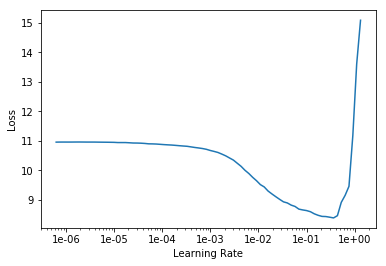

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, max_lr=1e-3)  #flipping the mask seemed to have caused a problem!

epoch,train_loss,valid_loss,time


In [ ]:
learn.recorder.plot_losses()

In [ ]:
x,y = next(iter(learn.data.valid_dl))
x,y[0,:]

In [ ]:
preds = learn.model(x,y)
preds[0][0,:].argmax(dim=-1)

In [ ]:
x_itos = data.label_list.train.x.vocab.itos
y_itos = data.label_list.train.y.vocab.itos

In [ ]:
i = 0
for i in range(5):
    print(' '.join([x_itos[o] for o in x[i,:] if o != 1]))
    print(' '.join([y_itos[o] for o in y[i,:] if o != 1]))
    print(' '.join([y_itos[o] for o in preds[0][i,:].argmax(dim=1) if o!=1]))
    print()

In [ ]:
def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encoder(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        try: out = model.decoder(Variable(ys), memory, src_mask, Variable(subsequent_mask(ys.size(1)).type_as(src.data)))
        except: set_trace()
        prob = F.softmax(model.out(out[:, -1]))

#         next_word = torch.multinomial(prob, 1)  #sample from distribution
#         next_word = next_word.data[0][0]

        next_word = prob.argmax(dim=-1).item()  ## single best
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

In [ ]:
m = learn.model.eval()

In [ ]:
src = x
trg = y
trg_input = trg[:,:-1]
# targets = trg[:, 1:].contiguous()
src_mask, _ = create_masks(src, trg_input)

In [ ]:
y.size(1)

In [ ]:
ys = greedy_decode(m, src[10].unsqueeze(0), src_mask[10], max_len=y.size(1), start_symbol=0)

In [ ]:
print(' '.join([x_itos[o] for o in src[10] if o != 1]))
print(' '.join([y_itos[o] for o in trg[10] if o != 1]))

In [ ]:
print(' '.join([y_itos[o] for o in ys[0,:] if o != 1]))